# Email Spam Classification - Data Preprocessing

This notebook performs exploratory data analysis and preprocessing for the spam classification model.

## Steps:
1. Load and explore data
2. Text cleaning and normalization
3. Tokenization and sequence creation
4. Train/test split
5. Save preprocessed data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Explore Data

In [15]:
# Load data
df = pd.read_csv('../data/train.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head(10)

Dataset shape: (5573, 2)

Columns: ['Category', 'Message']


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [16]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

Missing values:
Category    0
Message     0
dtype: int64

Data types:
Category    object
Message     object
dtype: object


Class distribution:
Category
ham               4825
spam               747
{"mode":"full"       1
Name: count, dtype: int64

Percentages:
Category
ham               86.578145
spam              13.403912
{"mode":"full"     0.017944
Name: proportion, dtype: float64


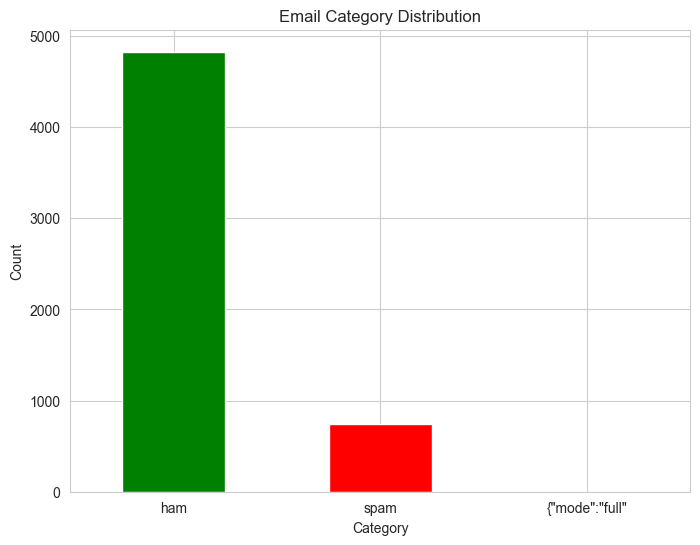

In [17]:
# Class distribution
print("Class distribution:")
print(df['Category'].value_counts())
print(f"\nPercentages:")
print(df['Category'].value_counts(normalize=True) * 100)

# Visualize distribution
plt.figure(figsize=(8, 6))
df['Category'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Email Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [18]:
# Message length analysis
df['message_length'] = df['Message'].str.len()

print("Message length statistics:")
print(df.groupby('Category')['message_length'].describe())

Message length statistics:
                 count       mean        std   min    25%    50%    75%    max
Category                                                                      
ham             4825.0   71.44829  58.434864   2.0   33.0   52.0   93.0  910.0
spam             747.0  137.98929  29.980287   7.0  132.0  149.0  157.0  223.0
{"mode":"full"     1.0   15.00000        NaN  15.0   15.0   15.0   15.0   15.0


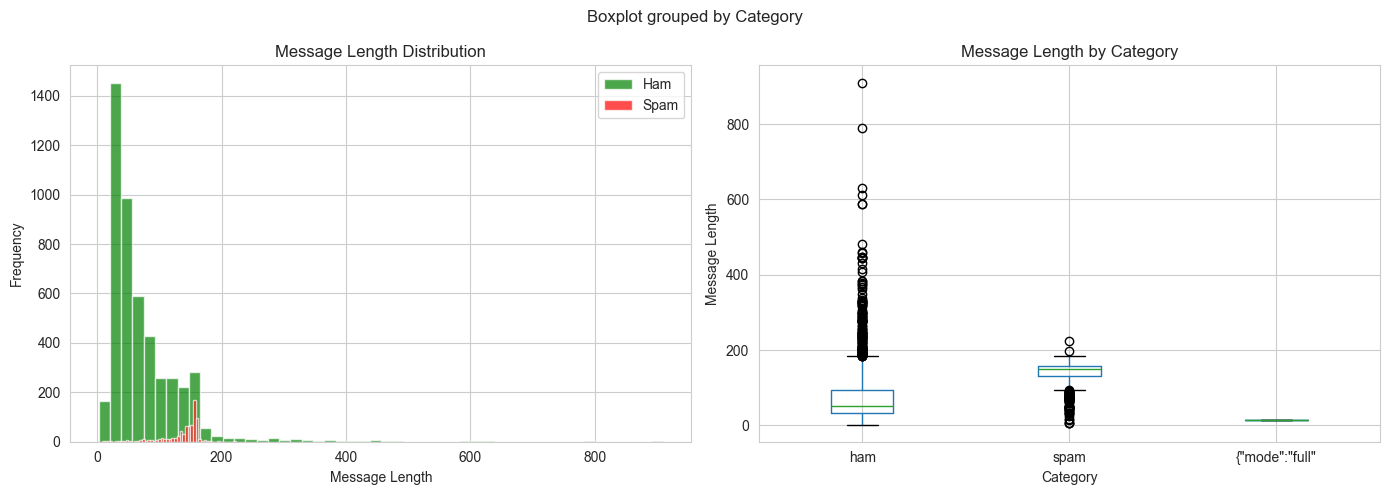

In [19]:
# Visualize message length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df[df['Category'] == 'ham']['message_length'].hist(bins=50, alpha=0.7, label='Ham', ax=axes[0], color='green')
df[df['Category'] == 'spam']['message_length'].hist(bins=50, alpha=0.7, label='Spam', ax=axes[0], color='red')
axes[0].set_xlabel('Message Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Message Length Distribution')
axes[0].legend()

# Box plot
df.boxplot(column='message_length', by='Category', ax=axes[1])
axes[1].set_title('Message Length by Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Message Length')

plt.tight_layout()
plt.show()

## 2. Text Cleaning and Normalization

In [20]:
def clean_text(text):
    """
    Clean and normalize email text.
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove phone numbers
    text = re.sub(r'\b\d{10,}\b', '', text)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
df['cleaned_message'] = df['Message'].apply(clean_text)

# Show examples
print("Cleaning examples:")
for i in range(5):
    print(f"\nOriginal: {df['Message'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['cleaned_message'].iloc[i][:100]}...")
    print("-" * 80)

Cleaning examples:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a...
Cleaned:  go until jurong point crazy available only in bugis n great world la e buffet cine there got amore w...
--------------------------------------------------------------------------------

Original: Ok lar... Joking wif u oni......
Cleaned:  ok lar joking wif u oni...
--------------------------------------------------------------------------------

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr...
Cleaned:  free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std t...
--------------------------------------------------------------------------------

Original: U dun say so early hor... U c already then say......
Cleaned:  u dun say so early hor u c already then say...
------------------------------------------------------------------------------

In [21]:
# Remove empty messages
df = df[df['cleaned_message'].str.len() > 0]
print(f"Dataset shape after removing empty messages: {df.shape}")

Dataset shape after removing empty messages: (5570, 4)


In [22]:
# Encode labels: ham=0, spam=1
df['label'] = df['Category'].map({'ham': 0, 'spam': 1})

print("Label encoding:")
print(df[['Category', 'label']].drop_duplicates())

Label encoding:
            Category  label
0                ham    0.0
2               spam    1.0
5572  {"mode":"full"    NaN


## 3. Tokenization and Sequence Creation

In [23]:
# Configuration
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_message'].values)

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"\nMost common words:")
word_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
for word, freq in word_freq:
    print(f"{word}: {freq}")

Vocabulary size: 7727

Most common words:
i: 3032
to: 2250
you: 2247
a: 1465
the: 1340
u: 1217
and: 980
in: 905
is: 896
me: 807
my: 767
it: 752
for: 711
your: 681
of: 623
call: 605
s: 589
that: 587
have: 575
on: 538


Sequence length statistics:
Mean: 15.60
Median: 12.00
Max: 190
Min: 1


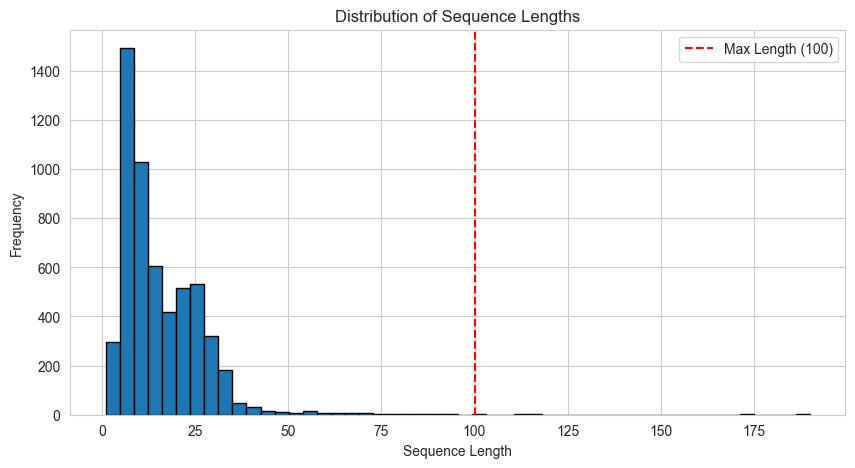


Percentage of sequences <= 100: 99.91%


In [24]:
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_message'].values)

# Analyze sequence lengths
seq_lengths = [len(seq) for seq in sequences]

print(f"Sequence length statistics:")
print(f"Mean: {np.mean(seq_lengths):.2f}")
print(f"Median: {np.median(seq_lengths):.2f}")
print(f"Max: {np.max(seq_lengths)}")
print(f"Min: {np.min(seq_lengths)}")

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(seq_lengths, bins=50, edgecolor='black')
plt.axvline(MAX_SEQUENCE_LENGTH, color='red', linestyle='--', label=f'Max Length ({MAX_SEQUENCE_LENGTH})')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()
plt.show()

print(f"\nPercentage of sequences <= {MAX_SEQUENCE_LENGTH}: {sum(l <= MAX_SEQUENCE_LENGTH for l in seq_lengths) / len(seq_lengths) * 100:.2f}%")

In [25]:
# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Padded sequences shape: {padded_sequences.shape}")
print(f"\nExample sequence:")
print(padded_sequences[0])

Padded sequences shape: (5570, 100)

Example sequence:
[  50  458 3902  797  723  633   69    9 1250   77  127  330  968  150
 2713 1251   63   62 3903  137    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## 4. Train/Test Split

In [26]:
# Split data
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Add sequences to dataframe
df['sequence'] = list(padded_sequences)

# Split
train_df, test_df = train_test_split(
    df, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=df['label']
)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTrain class distribution:")
print(train_df['Category'].value_counts())

print(f"\nTest class distribution:")
print(test_df['Category'].value_counts())

ValueError: Input y contains NaN.

## 5. Save Preprocessed Data

In [ ]:
# Save preprocessed dataframes
train_df.to_csv('../data/preprocessed_train.csv', index=False)
test_df.to_csv('../data/preprocessed_test.csv', index=False)

print("Preprocessed data saved!")
print(f"- Train: ../data/preprocessed_train.csv")
print(f"- Test: ../data/preprocessed_test.csv")

In [ ]:
# Save tokenizer
with open('../data/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved to ../data/tokenizer.pkl")

## Summary

✅ Data loaded and explored  
✅ Text cleaned and normalized  
✅ Tokenizer created and fitted  
✅ Sequences created and padded  
✅ Data split into train/test  
✅ Preprocessed data and tokenizer saved  

**Next Step**: Open `model.ipynb` to train the CNN spam classifier!